Image Deconvolution (PGM Plug-and-Play Priors w/ BM3D)
======================================================

This example demonstrates the use of class [pgm.AcceleratedPGM](../_autosummary/scico.pgm.rst#scico.pgm.AcceleratedPGM) to solve an image deconvolution problem using the Plug-and-Play Priors framework <cite data-cite="venkatakrishnan-2013-plugandplay2"/> <cite data-cite="kamilov-2017-plugandplay"/>, using BM3D <cite data-cite="dabov-2008-image"/> as a denoiser.

In [1]:
import numpy as np

import jax

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.pgm import AcceleratedPGM
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=512)
x_gt = jax.device_put(x_gt)  # Convert to jax type, push to GPU

Set up forward operator and test signal consisting of blurred signal with additive Gaussian noise.

In [3]:
n = 5  # Convolution kernel size
σ = 20.0 / 255  # Noise level

psf = snp.ones((n, n)) / n ** 2
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # Blurred image
noise, key = scico.random.randn(Ax.shape)
y = Ax + σ * noise

Set up and run a PGM solver

In [4]:
f = loss.SquaredL2Loss(y=y, A=A)

L0 = 15  # APGM inverse step size parameter
λ = L0 * 2.0 / 255  # BM3D regularization strength
g = λ * functional.BM3D()

maxiter = 50  # Number of APGM iterations

solver = AcceleratedPGM(f=f, g=g, L0=L0, x0=A.T @ y, maxiter=maxiter, verbose=True)

x = solver.solve()
x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)

Iter  Residual
--------------
   0  2.070e+00


   1  1.657e+00


   2  1.422e+00


   3  1.289e+00


   4  1.182e+00


   5  1.080e+00


   6  9.789e-01


   7  8.794e-01


   8  7.831e-01


   9  6.913e-01


  10  6.057e-01


  11  5.285e-01


  12  4.597e-01


  13  4.002e-01


  14  3.508e-01


  15  3.116e-01


  16  2.809e-01


  17  2.579e-01


  18  2.393e-01


  19  2.261e-01


  20  2.156e-01


  21  2.089e-01


  22  2.026e-01


  23  1.967e-01


  24  1.928e-01


  25  1.848e-01


  26  1.803e-01


  27  1.810e-01


  28  1.793e-01


  29  1.758e-01


  30  1.733e-01


  31  1.710e-01


  32  1.697e-01


  33  1.702e-01


  34  1.762e-01


  35  1.714e-01


  36  1.770e-01


  37  1.800e-01


  38  1.825e-01


  39  1.857e-01


  40  1.863e-01


  41  1.839e-01


  42  1.835e-01


  43  1.810e-01


  44  1.835e-01


  45  1.821e-01


  46  1.812e-01


  47  1.783e-01


  48  1.861e-01


  49  1.855e-01


Show the recovered image.

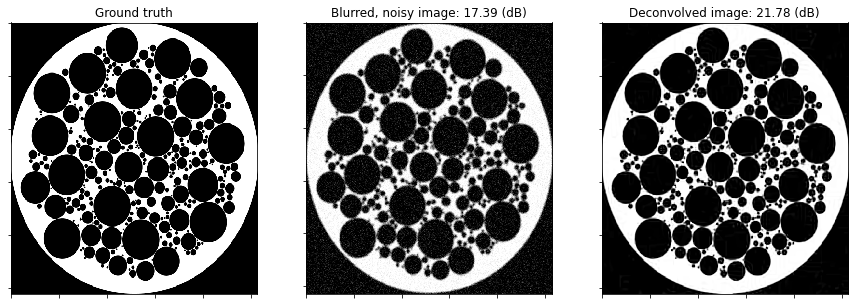

In [5]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
nc = n // 2
y = snp.clip(y, 0, 1)
yc = y[nc:-nc, nc:-nc]
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, yc), fig=fig, ax=ax[1])
plot.imview(x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

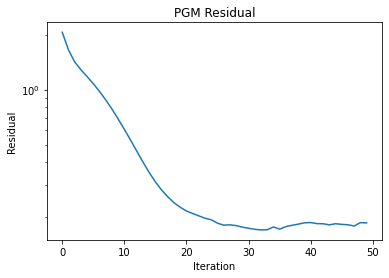

In [6]:
plot.plot(hist.Residual, ptyp="semilogy", title="PGM Residual", xlbl="Iteration", ylbl="Residual")